# Initiation and Engagement with Treatment Among Oregon Medicaid Beneficiaries with a New Episode of AOD, 2010-2020

## Exploratory Data Analysis

Next we look at the data for patterns, produce summary statistics, and create visualizations. 

### Declare imports

In [2]:
import pandas as pd
import psycopg2 as pg
from sqlalchemy import create_engine
import sqlalchemy
import io
import csv
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from tableone import TableOne
import matplotlib.ticker as mtick
import numpy as np
import warnings
import sqlite3
from datetime import date
warnings.filterwarnings('ignore')
%load_ext sql

### Print Version and Date

In [4]:
from platform import python_version

print("Python Version:", python_version())

Python Version: 3.9.7


In [5]:
today = date.today()
print("Today's date:", today)

Today's date: 2022-07-29


### Set file directories

In [6]:
user_file = "username.txt"
pw_file = "pw.txt"

### Set up user and password variables

#### User

In [7]:
try:
    uf = open(user_file, "r")
    user = uf.read().strip()
except (Exception, os.error) as error:
    print("Error while opening user file " + user_file + ": ", error)
finally:
    uf.close()

#### Password

In [8]:
try:
    pwf = open(pw_file, "r")
    pw = pwf.read().strip()
except (Exception, os.error) as error:
    print("Error while opening password file " + user_file + ": ", error)
finally:
    pwf.close()

### Database variables

In [9]:
db_server = "albus.ohsu.edu"
db_port = "5432"
db_user = user
db_password = pw
db_name = "hsd"

### Set the connection string for SQLAlchemy

In [10]:
connection_string = "postgresql://" + db_user + ":" + db_password +  "@" + db_server + ":" + db_port + "/" + db_name

iPython-sql, which will allow for SQL magic functions, should already be installed — this is the command to install if it isn't

In [9]:
# %pip install ipython-sql

In [10]:
#con_string = "postgresql+psycopg2://" + db_user + ":" + db_password +  "@" + db_server + ":" + db_port + "/" + db_name

In [11]:
#engine = create_engine(con_string)
#engine.connect()

### Connect SQLAlchemy

In [11]:
#Connect
%sql "$connection_string"

#### Set up the psycopg2 database connection

In [12]:
con = pg.connect(host = db_server, port = db_port, user= db_user, password = db_password, dbname = db_name)

### Rates of new AOD, initiation, and treatment


In [53]:
query = """select * from mem_detail;"""
mem_detail = pd.read_sql(query, con= con)

In [54]:
query = """select * from iet_mem_distinct;"""
iet_mem_distinct = pd.read_sql(query, con= con)

In [100]:
iet_wide = iet_mem_distinct.pivot(index=['member_id', 'year_ending'], columns='measure_id', values=['den', 'num'])
iet_wide = iet_wide.reset_index()
iet['memberid'] = iet_wide[('member_id', '')]
iet['yearending'] = iet_wide[('year_ending', '')]
iet['ini'] = iet_wide[('num', 'IET_E')]
iet['eng'] = iet_wide[('num', 'IET_I')]
iet['sud'] = iet_wide[('den', 'IET_I')]

In [104]:
iet['yearending'] = pd.to_datetime(iet['yearending'])
mem_detail['yearending'] = pd.to_datetime(mem_detail['yearending'])

In [105]:
fig = mem_detail.merge(iet, how='left', on=['memberid', 'yearending'])
fig['month'] = fig['yearending'].dt.month
fig = fig[fig['month']==12]

In [108]:
fig['sud'] = fig['sud'].fillna(0)
fig['ini'] = fig['ini'].fillna(0)
fig['eng'] = fig['eng'].fillna(0)

In [ ]:
fig['year'] = fig['yearending'].dt.year
fig

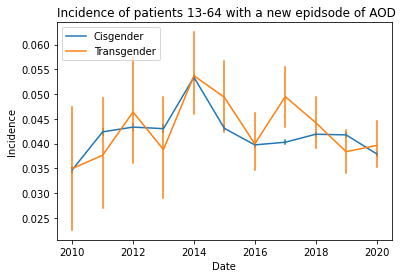

In [177]:
g = sns.lineplot(data=fig, x='year', y='sud', hue='t_ident', err_style='bars')
plt.legend(loc='upper left', labels=['Cisgender', 'Transgender'])
plt.xlabel("Date")
plt.ylabel("Incidence")
plt.title("Incidence of patients 13-64 with a new epidsode of AOD", loc='left')
plt.savefig('HEDIS_incidence', dpi=300)
plt.show(g)

**Caption:** Trans beneficiaries had similar rates of AOD over time - except 2017.

In [174]:
# Restrict to people with a SUD
aod = fig[fig['sud']==1]

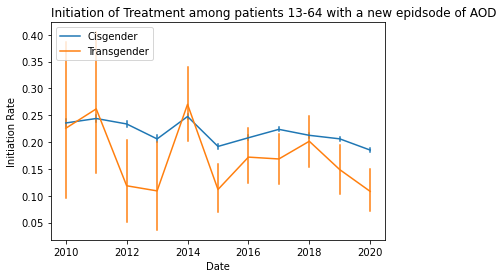

In [175]:
g = sns.lineplot(data=aod, x='year', y='ini', hue='t_ident', err_style='bars')

plt.legend(loc='upper left', labels=['Cisgender', 'Transgender'])
plt.xlabel("Date")
plt.ylabel("Initiation Rate")
plt.title("Initiation of Treatment among patients 13-64 with a new epidsode of AOD", loc='left')
plt.savefig('HEDIS_initiation', dpi=300)
plt.show(g)

**Caption:** In 2012, 2015, 2017, 2019, and 2020 - trans beneficiaries had lower rates of initiation of treatment.

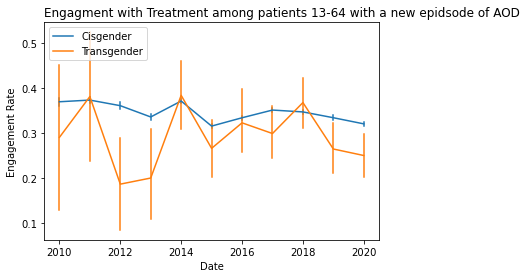

In [178]:
g = sns.lineplot(data=aod, x='year', y='eng', hue='t_ident', err_style='bars')

plt.legend(loc='upper left', labels=['Cisgender', 'Transgender'])
plt.xlabel("Date")
plt.ylabel("Engagement Rate")
plt.title("Engagment with Treatment among patients 13-64 with a new epidsode of AOD", loc='left')
plt.savefig('HEDIS_engagement', dpi=300)
plt.show(g)

**Caption:** In 2012, 2013, 2019, and 2020 - trans beneficiaries had lower rates of engagement with treatment.

In [32]:
query = """select * from aod_cohort;"""
group = pd.read_sql(query, con= con)

## Table 1

This is our Table 1 for the publication. We compare summary statistics between transgender and cisgender beneficiaries with a new AOD.

In [14]:
columns = ['age_grp', 'gender',  'race_eth', 'urban', 'mh', 'alc', 'opi', 'oth', 'poly', 'ovr', 'pain', 'cdps']
categorical =  ['age_grp', 'gender', 'race_eth']
decimals = 2
groupby = ['t_ident']

In [15]:
table1 = TableOne(group, columns, categorical, groupby, decimals= decimals, pval=True, htest_name = True)

In [16]:
table1

Grouped by t_ident                                                                        
                                                   Missing         Overall               0            1 P-Value               Test
n                                                                   257855          256320         1535                           
age_grp, n (%)   13-17                                   0    18457 (7.16)    18255 (7.12)  202 (13.16)  <0.001        Chi-squared
                 18-25                                       37598 (14.58)   37164 (14.50)  434 (28.27)                           
                 26-34                                       61541 (23.87)   61081 (23.83)  460 (29.97)                           
                 35-44                                       49441 (19.17)   49197 (19.19)  244 (15.90)                           
                 45-64                                       90818 (35.22)   90623 (35.36)  195 (12.70)                           
gender, n (%)    F                                       0  124765 (48.39)  123984 (48.37)  781 (50.88)   0.053        Chi-squared
                 M                                          133090 (51.61)  132336 (51.63)  754 (49.12)                           
race_eth, n (%)  Hispanic                                0    15564 (6.04)    15483 (6.04)    81 (5.28)  <0.001        Chi-squared
                 Non-Hispanic non-white                      37736 (14.63)   37490 (14.63)  246 (16.03)                           
                 Non-Hispanic white                         151500 (58.75)  150721 (58.80)  779 (50.75)                           
                 Unknown                                     53055 (20.58)   52626 (20.53)  429 (27.95)                           
urban, mean (SD)                                         0     0.60 (0.49)     0.60 (0.49)  0.74 (0.44)  <0.001  Two Sample T-test
mh, mean (SD)                                            0     0.41 (0.49)     0.41 (0.49)  0.65 (0.48)  <0.001  Two Sample T-test
alc, mean (SD)                                           0     0.35 (0.48)     0.35 (0.48)  0.33 (0.47)   0.280  Two Sample T-test
opi, mean (SD)                                           0     0.17 (0.38)     0.17 (0.38)  0.14 (0.35)   0.001  Two Sample T-test
oth, mean (SD)                                           0     0.25 (0.43)     0.25 (0.43)  0.29 (0.45)  <0.001  Two Sample T-test
poly, mean (SD)                                          0     0.53 (0.50)     0.53 (0.50)  0.58 (0.49)   0.001  Two Sample T-test
ovr, mean (SD)                                           0     0.03 (0.16)     0.03 (0.16)  0.08 (0.27)  <0.001  Two Sample T-test
pain, mean (SD)                                          0     0.38 (0.49)     0.38 (0.49)  0.42 (0.49)   0.001  Two Sample T-test
cdps, mean (SD)                                          0     0.53 (0.94)     0.53 (0.94)  0.70 (0.92)  <0.001  Two Sample T-test

In [50]:
# sent it to a excel book for required stylization
table1.to_excel('AOD_table1.xlsx')

### Visualize Proportions

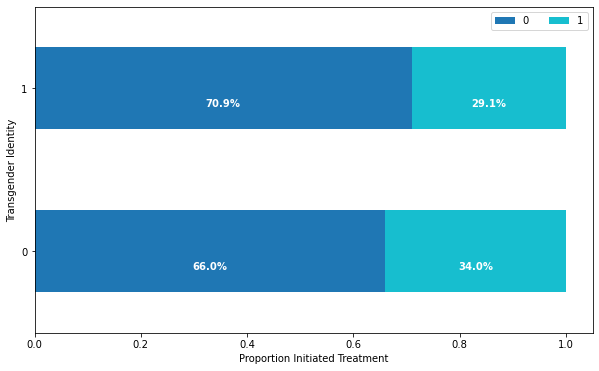

In [23]:
cross_tab_prop = pd.crosstab(index=[group['t_ident']], columns=group['iet_i_num'], normalize='index')
cross_tab = pd.crosstab(index=[group['t_ident']], columns=group['iet_i_num'])
cross_tab_prop.plot(kind='barh', stacked=True, colormap='tab10', figsize=(10,6))

plt.legend(loc='best', ncol=2)
plt.xlabel("Proportion Initiated Treatment")
plt.ylabel("Transgender Identity")
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                         cross_tab.loc[x],
                                         cross_tab_prop.loc[x].cumsum()):
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%',
                 color="white",
                 fontsize=10,
                 fontweight="bold",
                 horizontalalignment="center")
    
plt.show()

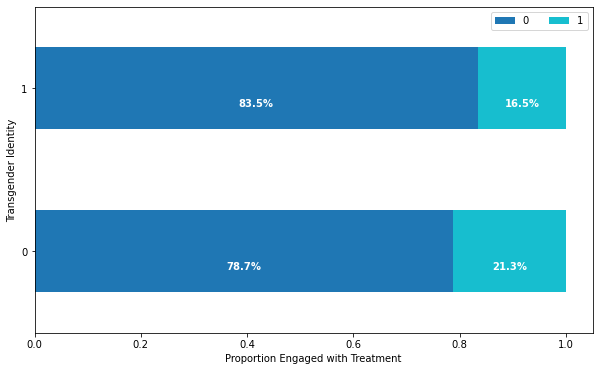

In [24]:
cross_tab_prop = pd.crosstab(index=[group['t_ident']], columns=group['iet_e_num'], normalize='index')
cross_tab = pd.crosstab(index=[group['t_ident']], columns=group['iet_e_num'])
cross_tab_prop.plot(kind='barh', stacked=True, colormap='tab10', figsize=(10,6))

plt.legend(loc='best', ncol=2)
plt.xlabel("Proportion Engaged with Treatment")
plt.ylabel("Transgender Identity")
for n, x in enumerate([*cross_tab.index.values]):
    for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                         cross_tab.loc[x],
                                         cross_tab_prop.loc[x].cumsum()):
        plt.text(x=(y_loc - proportion) + (proportion / 2),
                 y=n - 0.11,
                 s=f'{np.round(proportion * 100, 1)}%',
                 color="white",
                 fontsize=10,
                 fontweight="bold",
                 horizontalalignment="center")
    
plt.show()

## Exploratory Logistic Regression

In [33]:
import statsmodels.formula.api as smf
small = group[['iet_i_num', 'iet_e_num', 't_ident', 'gen_grp', 'age_grp', 'race_eth', 'urban',  'mh', 'alc', 'opi', 'poly', 'year', 'pain', 'cdps', 'memberid']]

Models are clustered by memberid to account for within member correlation.

###  Model 1: Initiation

In [34]:
model = smf.logit("iet_i_num ~ C(t_ident, Treatment(reference=1)) + age_grp +  urban + mh + pain + alc + opi + poly + cdps + C(year, Treatment(reference=10)) + C(race_eth, Treatment(reference=2))", data = small).fit(cov_type='cluster', cov_kwds={'groups': group['memberid']})
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = model.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in model.pvalues]
odds.to_excel('odds_initiation.xlsx')
odds

Optimization terminated successfully.
         Current function value: 0.626843
         Iterations 5


,2.5%,97.5%,Odds Ratio,pvalues,significant?
Intercept,0.330286,0.420204,0.372542,3.818922e-58,significant
"C(t_ident, Treatment(reference=1))[T.0]",1.139622,1.428767,1.276030,2.381928e-05,significant
age_grp[T.18-25],0.737393,0.794785,0.765552,2.299644e-44,significant
age_grp[T.26-34],0.844940,0.907546,0.875684,3.335769e-13,significant
age_grp[T.35-44],0.722553,0.778493,0.750001,1.148200e-51,significant
...,...,...,...,...,...
pain,0.807227,0.838945,0.822933,1.948249e-87,significant
alc,1.271360,1.336732,1.303636,1.866698e-95,significant
opi,1.678901,1.760783,1.719355,0.000000e+00,significant
poly,1.058281,1.113995,1.085781,3.220996e-10,significant


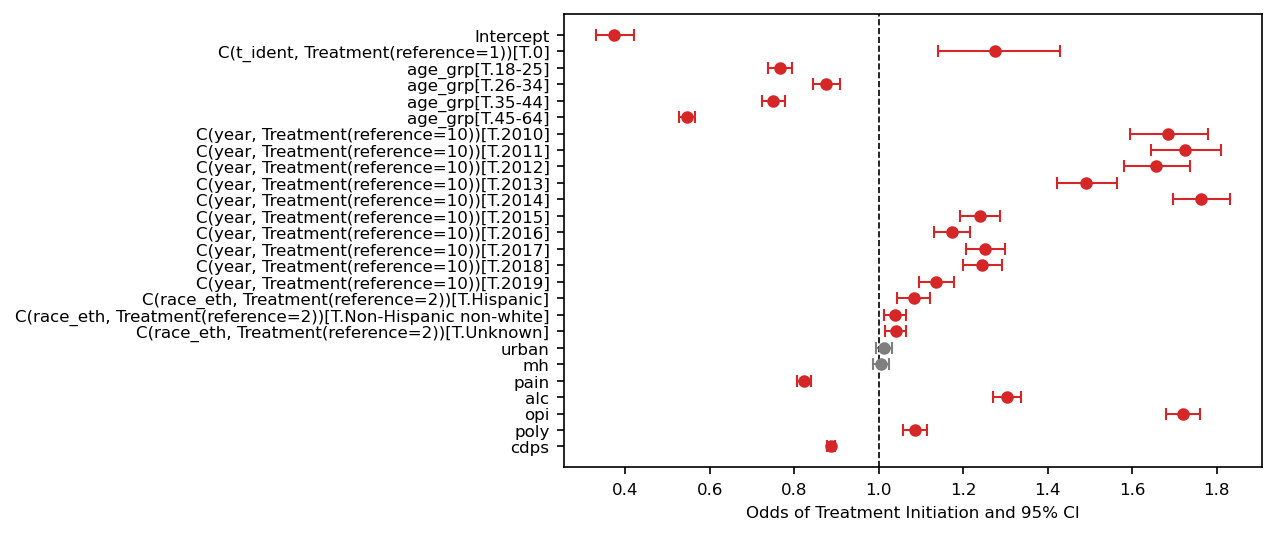

In [35]:
## Plot
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in odds.iloc[::-1].iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['significant?'] == 'significant':
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:gray", mec="tab:gray")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds of Treatment Initiation and 95% CI', fontsize=8)
#plt.tight_layout()
plt.savefig('odds_initiation.png')
plt.show()

### Model 2: Engagement

In [36]:
model = smf.logit("iet_e_num ~ C(t_ident, Treatment(reference=1)) + age_grp +  urban + mh + pain + alc + opi + cdps + C(year, Treatment(reference=10)) + C(race_eth, Treatment(reference=2))", data = small).fit(cov_type='cluster', cov_kwds={'groups': group['memberid']})
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = model.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in model.pvalues]
odds.to_excel('odds_engagement.xlsx')

Optimization terminated successfully.
         Current function value: 0.498627
         Iterations 6


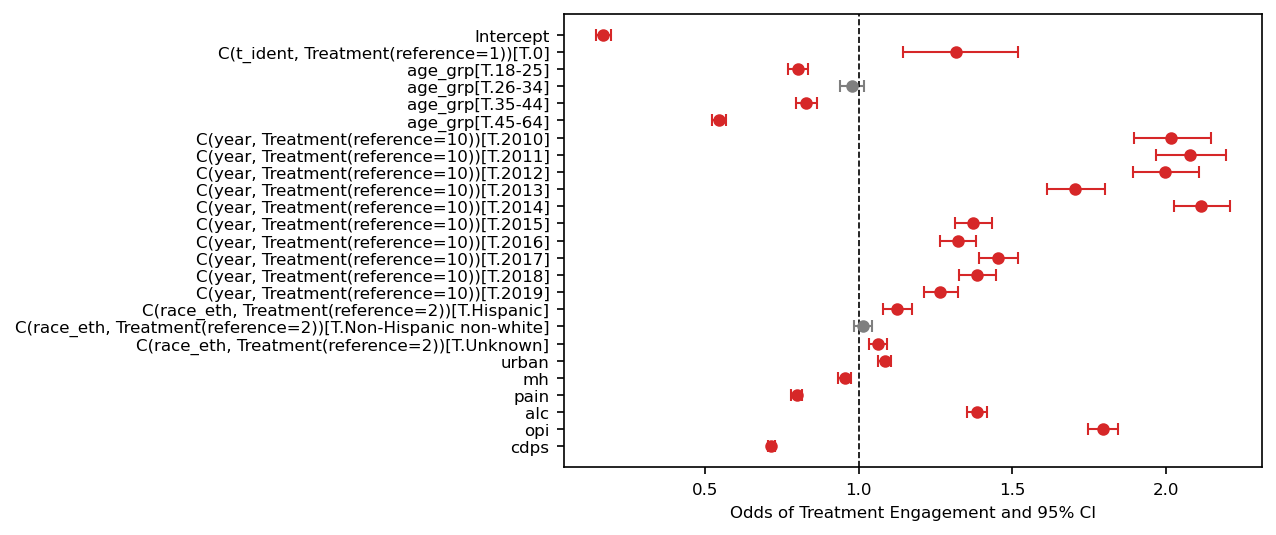

In [37]:
## Plot
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in odds.iloc[::-1].iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['significant?'] == 'significant':
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:gray", mec="tab:gray")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds of Treatment Engagement and 95% CI', fontsize=8)
#plt.tight_layout()
plt.savefig('odds_engagement.png')
plt.show()

**Summary:** We found that cisgender beneficiaries have a higher odds of initiating and engaging with treatment compared to transgender beneficiaries, even after controlling for age, race, urbanicity, mental health, pain diagnoses, cdps risk score, and type of diagnoses.

## Sensitivity Analyses

Since treatment engagement and initiation varies among people with alcohol use disorders, opioid use disorders, and polysubstance use - lets look at each condition separately.

### Alcohol Only

In [38]:
alc = small[small['alc']==1]

In [39]:
#Models
model = smf.logit("iet_i_num ~ C(t_ident, Treatment(reference=1)) + age_grp +  urban + mh + pain + cdps + C(year, Treatment(reference=10)) + C(race_eth, Treatment(reference=2))", data = alc).fit(cov_type='cluster', cov_kwds={'groups': alc['memberid']})
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = model.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in model.pvalues]
odds.to_excel('odds_initiation_alc.xlsx')
odds

Optimization terminated successfully.
         Current function value: 0.638213
         Iterations 5


,2.5%,97.5%,Odds Ratio,pvalues,significant?
Intercept,0.329185,0.499892,0.405656,2.544753e-17,significant
"C(t_ident, Treatment(reference=1))[T.0]",1.101987,1.624332,1.337906,3.269872e-03,significant
age_grp[T.18-25],0.911547,1.074181,0.989528,8.015406e-01,not significant
age_grp[T.26-34],1.117312,1.303483,1.206813,1.741054e-06,significant
age_grp[T.35-44],0.923455,1.079386,0.998381,9.675231e-01,not significant
...,...,...,...,...,...
"C(race_eth, Treatment(reference=2))[T.Unknown]",1.015230,1.088516,1.051234,4.953484e-03,significant
urban,0.968635,1.026953,0.997368,8.597255e-01,not significant
mh,0.988955,1.053846,1.020885,2.023403e-01,not significant
pain,0.898393,0.959180,0.928289,8.380860e-06,significant


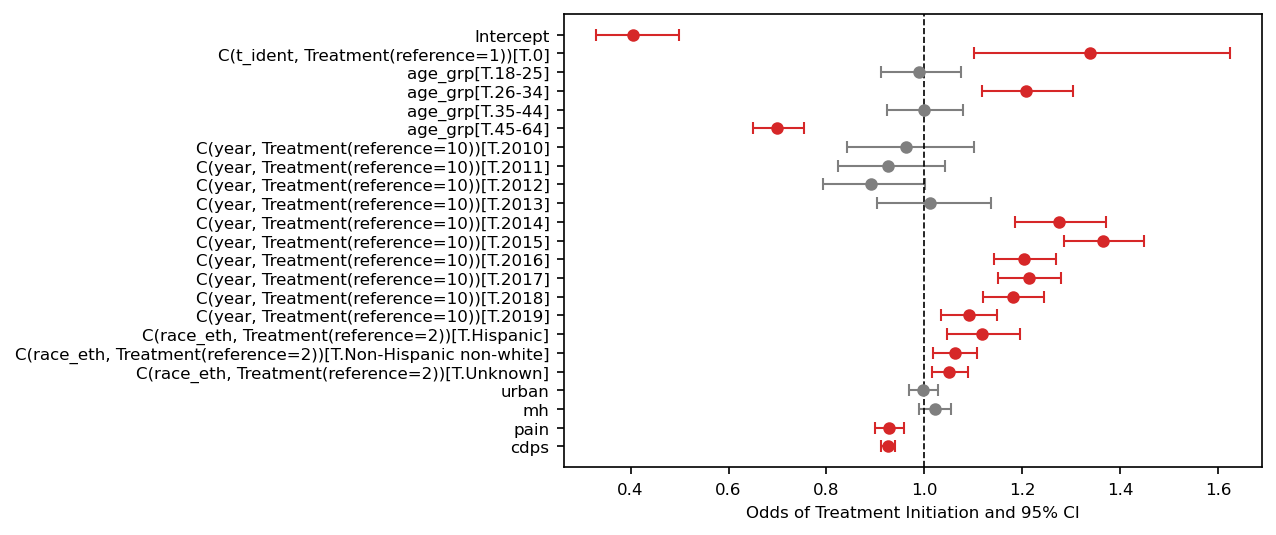

In [40]:
## Plot
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in odds.iloc[::-1].iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['significant?'] == 'significant':
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:gray", mec="tab:gray")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds of Treatment Initiation and 95% CI', fontsize=8)
#plt.tight_layout()
plt.savefig('odds_initiation_alc.png')
plt.show()

### Opioid Use

In [41]:
opi = small[small['opi']==1]
opi['iet_i_num'].describe()

count    44792.000000
mean         0.407885
std          0.491447
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: iet_i_num, dtype: float64

In [42]:
#Model
model = smf.logit("iet_e_num ~ C(t_ident, Treatment(reference=1))  + age_grp +  urban + mh + pain + cdps + C(year, Treatment(reference=10)) + C(race_eth, Treatment(reference=2))", data = opi).fit(cov_type='cluster', cov_kwds={'groups': opi['memberid']})
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = model.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in model.pvalues]
odds.to_excel('odds_initiation_opi.xlsx')
odds

Optimization terminated successfully.
         Current function value: 0.557098
         Iterations 6


,2.5%,97.5%,Odds Ratio,pvalues,significant?
Intercept,0.273238,0.617534,0.410772,1.892222e-05,significant
"C(t_ident, Treatment(reference=1))[T.0]",0.746431,1.477841,1.050288,7.782642e-01,not significant
age_grp[T.18-25],0.720219,1.140480,0.906309,4.014945e-01,not significant
age_grp[T.26-34],0.812269,1.272238,1.016563,8.858891e-01,not significant
age_grp[T.35-44],0.690841,1.086469,0.866359,2.142477e-01,not significant
...,...,...,...,...,...
"C(race_eth, Treatment(reference=2))[T.Unknown]",0.982355,1.092740,1.036078,1.920147e-01,not significant
urban,1.120547,1.230379,1.174180,1.680186e-11,significant
mh,0.991941,1.095618,1.042491,1.008192e-01,not significant
pain,0.625078,0.694402,0.658829,1.529173e-54,significant


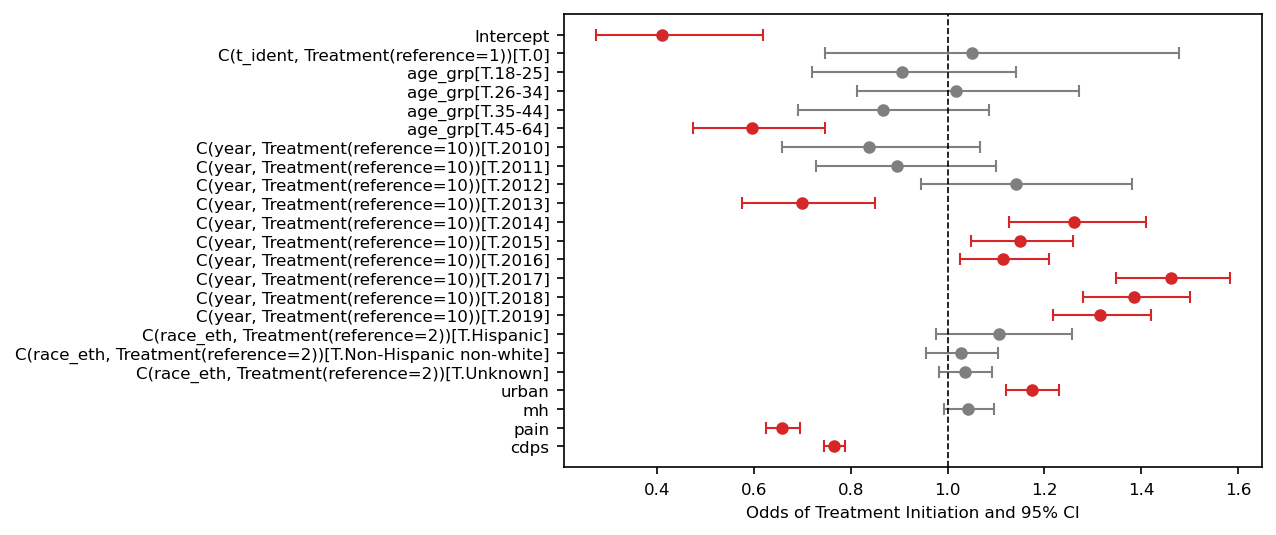

In [43]:
## Plot
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in odds.iloc[::-1].iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['significant?'] == 'significant':
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:gray", mec="tab:gray")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds of Treatment Initiation and 95% CI', fontsize=8)
#plt.tight_layout()
plt.savefig('odds_initiation_opi.png')
plt.show()

### Polysubstance

In [44]:
poly = small[small['poly']==1]

In [46]:
model = smf.logit("iet_e_num ~ C(t_ident, Treatment(reference=1))  + age_grp +  urban +  mh + pain + cdps + C(year, Treatment(reference=10)) + C(race_eth, Treatment(reference=2))", data = poly).fit(cov_type='cluster', cov_kwds={'groups': poly['memberid']})
model_odds = pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(model.conf_int())
params = model.params
conf = model.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
odds['pvalues'] = model.pvalues
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in model.pvalues]
odds.to_excel('odds_initiation_poly.xlsx')
odds

Optimization terminated successfully.
         Current function value: 0.491503
         Iterations 6


,2.5%,97.5%,Odds Ratio,pvalues,significant?
Intercept,0.142446,0.213572,0.174420,4.388129e-64,significant
"C(t_ident, Treatment(reference=1))[T.0]",1.147503,1.675922,1.386768,7.147405e-04,significant
age_grp[T.18-25],1.004874,1.166062,1.082472,3.679210e-02,significant
age_grp[T.26-34],1.234740,1.420607,1.324417,4.013026e-15,significant
age_grp[T.35-44],1.012798,1.169101,1.088147,2.103860e-02,significant
...,...,...,...,...,...
"C(race_eth, Treatment(reference=2))[T.Unknown]",1.040136,1.110913,1.074943,1.683641e-05,significant
urban,1.017212,1.075760,1.046077,1.603180e-03,significant
mh,0.950595,1.010106,0.979899,1.899166e-01,not significant
pain,0.865438,0.921867,0.893207,2.406734e-12,significant


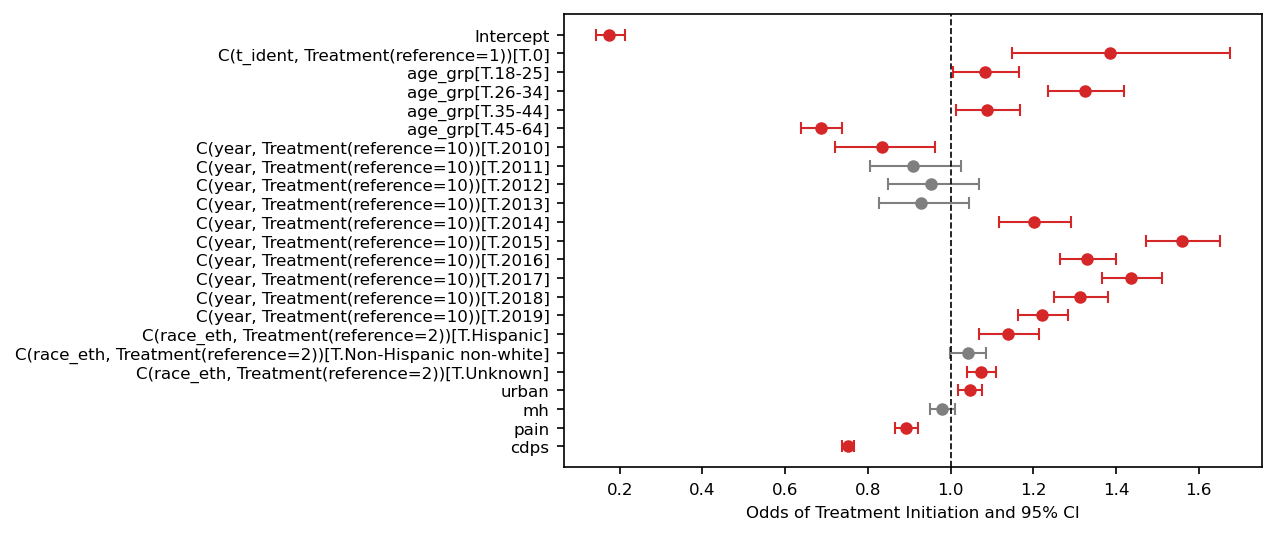

In [47]:
## Plot
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in odds.iloc[::-1].iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['significant?'] == 'significant':
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o", 
                     markersize=5, mfc="tab:gray", mec="tab:gray")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds of Treatment Initiation and 95% CI', fontsize=8)
#plt.tight_layout()
plt.savefig('odds_initiation_poly.png')
plt.show()

**Findings:** Similar results for those with alcohol or polysubstance use disorders. No differences were found in initiation of treatment among those with opioid use disorders.